In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Dataset attributes

- **site_id** - ID code for the source hospital.
- **patient_id** - ID code for the patient.
- **image_id** - ID code for the image.
- **laterality** - Whether the image is of the left (L) or right (R) breast.
- **view** - The orientation of the image. The default for a screening exam is to capture two views per breast.
- **age** - The patient's age in years.
- **cancer** - Whether or not the breast was positive for malignant cancer. The target value. Only provided for train.
- **biopsy** - Whether or not a follow-up biopsy was performed on the breast. Only provided for train.
- **invasive** - If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train.
- **BIRADS** - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train.
- **implant** - Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level.
- **density** - A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult. Only provided for train.
- **machine_id** - An ID code for the imaging device.
- **difficult_negative_case** - True if the case was unusually difficult. Only provided for train.

## BASE DE TREINAMENTO

In [2]:
df_train = pd.read_csv("train.csv", sep=",")
df_train

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43739,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
43740,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
43741,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
43742,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [3]:
# Número total de imagens:
print("Número total de imagens: ", df_train["image_id"].count())

# Vamos analisar os números com relação aos hospitais (site_id):
print("Número de diferentes hospitais: ", df_train["site_id"].nunique(), ", cujos códigos são: ", df_train["site_id"].unique())
print("Distribuição de imagens por hospital: ", df_train.groupby("site_id").agg(qtde=("image_id","count")).reset_index())

# Número de pacientes distintos (patient_id):
print("Número de pacientes distintos:" , df_train["patient_id"].nunique())

# Distribuição de imagens com relação a lateralidade (laterality):
print("Número de imagens de seios esquerdos (L) e direitos (R):" , df_train.groupby("laterality").agg(qtde=("image_id","count")).reset_index())

# Distribuição de imagens com relação a sua orientação (view):
print("Número de imagens em cada orientação:" , df_train.groupby("view").agg(qtde=("image_id","count")).reset_index().sort_values(by="qtde", ascending=False))

# Número de imagens com implante (implant):
print("Número de imagens com e sem implante:" , df_train.groupby("implant").agg(qtde=("image_id","count")).reset_index())

# Número de imagens com e sem Câncer (cancer):
print("Número de imagens com e sem Câncer:" , df_train.groupby("cancer").agg(qtde=("image_id","count")).reset_index())

# Número de imagens positivas para câncer classificadas como invasivas (invasive):
print("Número de imagens positivas para câncer classificadas como invasivas:" , df_train[df_train["cancer"]==1].groupby("invasive").agg(qtde=("image_id","count")).reset_index())

# Número de imagens classificadas como extraordinariamente dificeis (difficult_negative_case):
print("Número de imagens classificadas como extraordinariamente dificeis:" , df_train.groupby("difficult_negative_case").agg(qtde=("image_id","count")).reset_index())

# Distribuição de imagens de acordo com a densidade do tecido mamário (density):
print("Distribuição de imagens de acordo com a densidade do tecido mamário: ", df_train.groupby("density").agg(qtde=("image_id","count")).reset_index())

# Relação entre diagnósticos de cancer com biópsias (cancer, biopsy):
print("Relação entre diagnósticos de cancer com biópsias: ", df_train.groupby(["cancer", "biopsy"]).agg(qtde=("image_id","count")).reset_index())

Número total de imagens:  43744
Número de diferentes hospitais:  2 , cujos códigos são:  [2 1]
Distribuição de imagens por hospital:     site_id   qtde
0        1  23709
1        2  20035
Número de pacientes distintos: 9530
Número de imagens de seios esquerdos (L) e direitos (R):   laterality   qtde
0          L  21806
1          R  21938
Número de imagens em cada orientação:   view   qtde
5  MLO  22302
1   CC  21413
0   AT     16
4   ML      7
2   LM      5
3  LMO      1
Número de imagens com e sem implante:    implant   qtde
0        0  42587
1        1   1157
Número de imagens com e sem Câncer:    cancer   qtde
0       0  42778
1       1    966
Número de imagens positivas para câncer classificadas como invasivas:    invasive  qtde
0         0   273
1         1   693
Número de imagens classificadas como extraordinariamente dificeis:    difficult_negative_case   qtde
0                    False  37537
1                     True   6207
Distribuição de imagens de acordo com a densidade d

* Pelos números acima, vemos que existe um desbalanceamento enorme para a classe negativa de câncer (97,8%) contra a positiva (2,2%);
* Existem pouquíssimas imagens com implantes (2,65%);
* Mais de 99% das imagens estão orientadas nas posições CC (craniocaudal) e MLO (mediolateral obliquo);
* Há um balanço no número de imagens com relação ao hospital de origem e lado dos seios;
* Identificamos 6207 imagens que estão classificadas como extraordinariamente dificeis;
* Das 966 imagens positivas para câncer, cerca de 40% não são invasivas;
* A distribuição de imagens de acordo com a densidade do tecido mamário tem uma concentração para os níveis B e C (densidades médias);
* No total tivemos 2.442 imagens com biópsias. Todos os casos de cancer positivo tiveram biópsias. Não houve casos de cancer positivo sem biópsia.



In [4]:
# Análise dos campos buscando valores faltantes:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43744 entries, 0 to 43743
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  43744 non-null  int64  
 1   patient_id               43744 non-null  int64  
 2   image_id                 43744 non-null  int64  
 3   laterality               43744 non-null  object 
 4   view                     43744 non-null  object 
 5   age                      43720 non-null  float64
 6   cancer                   43744 non-null  int64  
 7   biopsy                   43744 non-null  int64  
 8   invasive                 43744 non-null  int64  
 9   BIRADS                   20959 non-null  float64
 10  implant                  43744 non-null  int64  
 11  density                  23674 non-null  object 
 12  machine_id               43744 non-null  int64  
 13  difficult_negative_case  43744 non-null  bool   
dtypes: bool(1), float64(2)

Identificamos 3 campos com valores faltantes:
* **age**     - 24 registros nulos. **Sugestão**: Substituir os valores faltantes pela média;
* **BIRADS**  - 22.785 registros nulos (52%). **Sugestão**: O campo está disponível apenas no conjunto de treinamento;
* **density** - 20.070 registros nulos (46%). **Sugestão**: O campo está disponível apenas no conjunto de treinamento;

## BASE DE TESTE

In [5]:
df_test = pd.read_csv("test.csv", sep=",")
df_test

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10048,964141995,L,MLO,62.0,0,0,0,NaN,0,NaN,29,False
1,2,10048,1234933874,L,CC,62.0,0,0,0,NaN,0,NaN,29,False
2,2,10048,1577142909,R,MLO,62.0,0,0,0,NaN,0,NaN,29,False
3,2,10048,1842203124,R,CC,62.0,0,0,0,NaN,0,NaN,29,False
4,2,10050,588678397,L,MLO,67.0,0,0,0,NaN,0,NaN,29,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10957,2,9965,1990076391,R,MLO,67.0,0,0,0,NaN,0,NaN,21,False
10958,2,9968,766198919,L,CC,76.0,0,0,0,NaN,0,NaN,48,False
10959,2,9968,2098937312,L,MLO,76.0,0,0,0,NaN,0,NaN,48,False
10960,2,9968,294168046,R,MLO,76.0,0,0,0,NaN,0,NaN,48,False


In [6]:
# Número total de imagens:
print("Número total de imagens: ", df_test["image_id"].count())

# Vamos analisar os números com relação aos hospitais (site_id):
print("Número de diferentes hospitais: ", df_test["site_id"].nunique(), ", cujos códigos são: ", df_test["site_id"].unique())
print("Distribuição de imagens por hospital: ", df_test.groupby("site_id").agg(qtde=("image_id","count")).reset_index())

# Número de pacientes distintos (patient_id):
print("Número de pacientes distintos:" , df_test["patient_id"].nunique())

# Distribuição de imagens com relação a lateralidade (laterality):
print("Número de imagens de seios esquerdos (L) e direitos (R):" , df_test.groupby("laterality").agg(qtde=("image_id","count")).reset_index())

# Distribuição de imagens com relação a sua orientação (view):
print("Número de imagens em cada orientação:" , df_test.groupby("view").agg(qtde=("image_id","count")).reset_index().sort_values(by="qtde", ascending=False))

# Número de imagens com implante (implant):
print("Número de imagens com e sem implante:" , df_test.groupby("implant").agg(qtde=("image_id","count")).reset_index())

Número total de imagens:  10962
Número de diferentes hospitais:  2 , cujos códigos são:  [2 1]
Distribuição de imagens por hospital:     site_id  qtde
0        1  5810
1        2  5152
Número de pacientes distintos: 2383
Número de imagens de seios esquerdos (L) e direitos (R):   laterality  qtde
0          L  5461
1          R  5501
Número de imagens em cada orientação:   view  qtde
4  MLO  5601
1   CC  5352
2   LM     5
0   AT     3
3   ML     1
Número de imagens com e sem implante:    implant   qtde
0        0  10642
1        1    320


Inicialmente vou considerar a solução mais simple de todas. Não trabalhar em nenhuma imagem e balancear o conjunto realizando um undersampling

In [7]:
df_train["img_path"] =  "train_images/" + df_train["patient_id"].astype(str) + "/" + df_train["image_id"].astype(str) + ".png"
df_train

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,train_images/10006/462822612.png
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,train_images/10006/1459541791.png
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,train_images/10006/1864590858.png
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,train_images/10006/1874946579.png
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,train_images/10011/220375232.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43739,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False,train_images/9973/1729524723.png
43740,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False,train_images/9989/63473691.png
43741,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False,train_images/9989/1078943060.png
43742,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True,train_images/9989/398038886.png


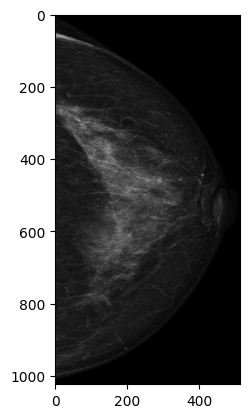

In [10]:
# Testando o caminho de uma imagem
img = cv2.imread(df_train.loc[0, 'img_path'])
plt.imshow(img, cmap = 'gray')

In [11]:
# Vamos separar os dados em treinamento e validação na proporção 80/20:
df_train_split, df_val_split = train_test_split(df_train, test_size = 0.2, random_state = 123456, stratify = df_train[['cancer']])

print("Número de imagens no conjunto de treinamento: ", df_train_split.shape[0])
print("Distribuição de cancer conjunto de treinamento: ", df_train_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())
print("Número de imagens no conjunto de validação: ", df_val_split.shape[0])
print("Distribuição de cancer no conjunto de validação: ", df_val_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())

Número de imagens no conjunto de treinamento:  34995
Distribuição de cancer conjunto de treinamento:     cancer   qtde
0       0  34222
1       1    773
Número de imagens no conjunto de validação:  8749
Distribuição de cancer no conjunto de validação:     cancer  qtde
0       0  8556
1       1   193


In [12]:
# Nesse momento, vou aplicar o undersampling escolhendo aleatoriamente 900 imagens sem cancer no conjunto de treinamento. 
df_train_split = pd.concat([df_train_split[df_train_split["cancer"]==1], df_train_split[df_train_split["cancer"]==0].sample(n=900)])
df_train_split = df_train_split.sample(n=df_train_split.shape[0])
print(df_train_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())
df_train_split

   cancer  qtde
0       0   900
1       1   773


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_path
12652,2,26974,592583896,R,MLO,71.0,1,1,0,NaN,0,NaN,48,False,train_images/26974/592583896.png
1079,1,11341,1810004579,L,CC,48.0,1,1,1,0.0,0,C,170,False,train_images/11341/1810004579.png
38308,2,61688,1190690412,R,CC,50.0,0,0,0,NaN,0,NaN,21,False,train_images/61688/1190690412.png
6271,1,18399,598556705,R,MLO,53.0,1,1,1,0.0,0,C,170,False,train_images/18399/598556705.png
43051,1,9029,302179668,R,MLO,83.0,1,1,1,0.0,0,B,49,False,train_images/9029/302179668.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39618,2,63459,386323815,R,MLO,57.0,0,0,0,NaN,0,NaN,48,False,train_images/63459/386323815.png
29324,1,49461,602369659,R,MLO,56.0,1,1,1,0.0,0,C,49,False,train_images/49461/602369659.png
13668,1,28344,1940528865,L,MLO,61.0,1,1,1,0.0,0,B,49,False,train_images/28344/1940528865.png
257,2,10329,1474367410,L,MLO,49.0,0,0,0,NaN,0,NaN,21,False,train_images/10329/1474367410.png


In [13]:
# Já para validação, vou escolher 230 imagens seguindo a mesma ideia.
df_val_split = pd.concat([df_val_split[df_val_split["cancer"]==1], df_val_split[df_val_split["cancer"]==0].sample(n=230)])
df_val_split = df_val_split.sample(n=df_val_split.shape[0])
print(df_val_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())
df_val_split

   cancer  qtde
0       0   230
1       1   193


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_path
31928,2,53272,1874310597,L,CC,73.0,1,1,1,NaN,0,NaN,48,False,train_images/53272/1874310597.png
22736,1,40411,1639684878,L,CC,60.0,0,0,0,0.0,0,C,49,True,train_images/40411/1639684878.png
37100,2,59993,773163128,R,CC,54.0,0,0,0,NaN,0,NaN,21,False,train_images/59993/773163128.png
35162,2,57623,1317268595,R,MLO,51.0,1,1,0,NaN,0,NaN,29,False,train_images/57623/1317268595.png
27073,2,46471,754737707,R,MLO,70.0,0,0,0,NaN,0,NaN,21,False,train_images/46471/754737707.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867,2,11087,1405254412,L,MLO,60.0,0,0,0,NaN,0,NaN,29,False,train_images/11087/1405254412.png
1975,2,12587,786323239,R,MLO,68.0,0,0,0,NaN,0,NaN,29,False,train_images/12587/786323239.png
26235,2,45326,710475374,L,CC,58.0,0,0,0,0.0,0,NaN,21,True,train_images/45326/710475374.png
43018,2,9008,947101947,L,MLO,62.0,0,0,0,NaN,0,NaN,21,False,train_images/9008/947101947.png


In [15]:
# Iremos agora criar 4 diretórios (2 de teste e 2 de validação, um de positivos e outro de negativos para cancer)

dir_path_train = "train_images/baseline/train"
dir_path_val = "train_images/baseline/val"

# Criando os diretórios:
if os.path.exists(dir_path_train):
    shutil.rmtree(dir_path_train)
else:
    os.makedirs(dir_path_train)
    
if os.path.exists(dir_path_val):
    shutil.rmtree(dir_path_val)
else:
    os.makedirs(dir_path_val)
    

# Criando os subdiretórios
os.makedirs(dir_path_train+"/with_cancer")
for path in df_train_split[df_train_split["cancer"]==1]['img_path']:
    shutil.copy2(path, dir_path_train+"/with_cancer")

os.makedirs(dir_path_train+"/wout_cancer")
for path in df_train_split[df_train_split["cancer"]==0]['img_path']:
    shutil.copy2(path, dir_path_train+"/wout_cancer")
    
os.makedirs(dir_path_val+"/with_cancer")
for path in df_val_split[df_val_split["cancer"]==1]['img_path']:
    shutil.copy2(path, dir_path_val+"/with_cancer")
    
os.makedirs(dir_path_val+"/wout_cancer")
for path in df_val_split[df_val_split["cancer"]==0]['img_path']:
    shutil.copy2(path, dir_path_val+"/wout_cancer")

In [16]:
# Criando geradores de imagem para o tensorflow:
train_datagen = ImageDataGenerator(rescale = 1./255., zoom_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255.,)

In [17]:
train_generator = train_datagen.flow_from_directory(
    dir_path_train,
    target_size = (1024, 512),
    batch_size = 32,
    class_mode = 'binary')
validation_generator = val_datagen.flow_from_directory(
        dir_path_val,
        target_size = (1024, 512),
        batch_size = 16,
        class_mode = 'binary')

Found 1673 images belonging to 2 classes.
Found 423 images belonging to 2 classes.


In [21]:
model_resnet50 = tf.keras.applications.ResNet50(weights = 'imagenet', input_shape = (1024, 512, 3), include_top = False)

for layer in model_resnet50.layers:
    layer.trainable = False
    
model = Sequential()
model.add(model_resnet50)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

94765736/94765736 [==============================] - 4s 0us/step


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 32, 16, 2048)      23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,850,113
Trainable params: 262,401
Non-trainable params: 23,587,712
______________________________________

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20, epochs = 15, callbacks = callback)

Epoch 1/15


2023-06-16 09:48:08.029402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - ETA: 0s - loss: 1.2835 - accuracy: 0.5156 

2023-06-16 10:02:20.363072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 1311s 65s/step - loss: 1.2835 - accuracy: 0.5156 - val_loss: 0.9941 - val_accuracy: 0.5437
Epoch 2/15
20/20 [==============================] - 1185s 60s/step - loss: 0.8292 - accuracy: 0.4959 - val_loss: 0.7065 - val_accuracy: 0.4563
Epoch 3/15
20/20 [==============================] - 1224s 62s/step - loss: 0.7658 - accuracy: 0.4891 - val_loss: 0.7367 - val_accuracy: 0.5437
Epoch 4/15
20/20 [==============================] - 1195s 61s/step - loss: 0.7338 - accuracy: 0.4814 - val_loss: 0.7284 - val_accuracy: 0.5437
Epoch 5/15
20/20 [==============================] - 1194s 61s/step - loss: 0.7261 - accuracy: 0.4976 - val_loss: 0.7018 - val_accuracy: 0.4563
Epoch 6/15
20/20 [==============================] - 1214s 62s/step - loss: 0.6930 - accuracy: 0.5251 - val_loss: 0.6876 - val_accuracy: 0.5414
Epoch 7/15
20/20 [==============================] - 1226s 62s/step - loss: 0.7054 - accuracy: 0.4750 - val_loss: 0.7002 - val_accuracy: 0.4563
Epoch 8/15

In [24]:
model.save('baseline_resnet50.h5')

In [25]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0, 0.5, 'loss')

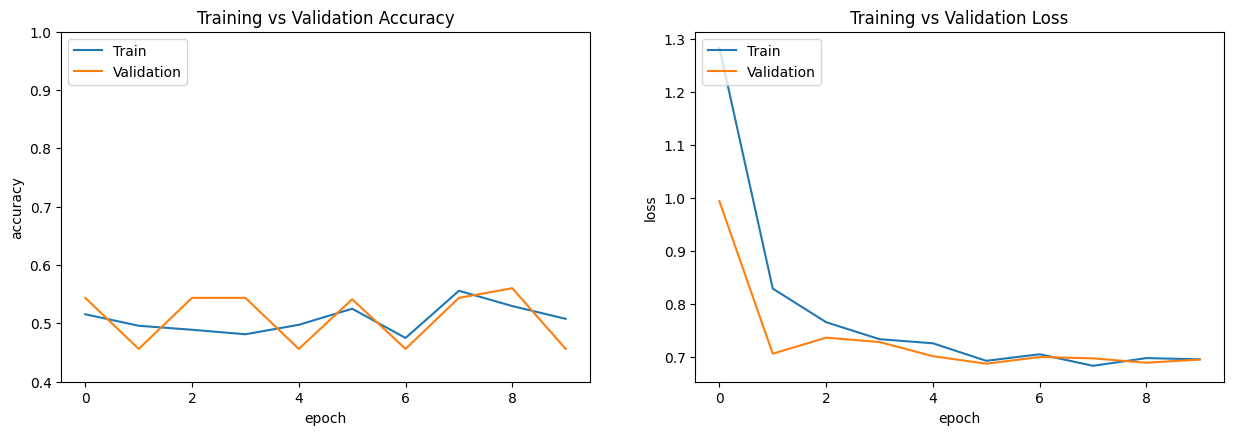

In [26]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

Text(50.722222222222214, 0.5, 'Real')

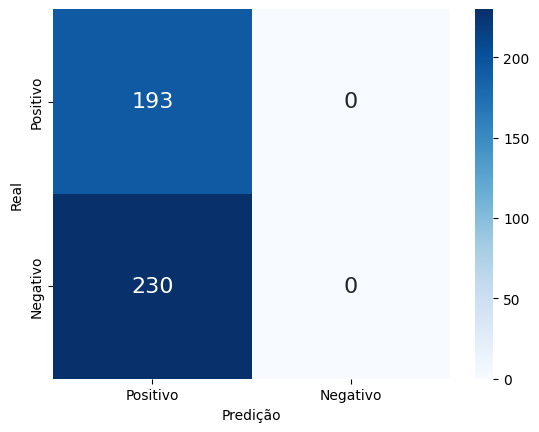

In [31]:
#model_resnet50 = load_model('baseline_resnet50.h5')

#pred_resnet50 = model_resnet50.predict(validation_generator)

y_pred_resnet50 = []
for prob in pred_resnet50:
    if prob >= 0.5:
        y_pred_resnet50.append(1)
    else:
        y_pred_resnet50.append(0)
        
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred_resnet50)

class_names = ['Positivo', 'Negativo']

ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

ax.set_xlabel("Predição")
ax.set_ylabel("Real")

In [30]:
pred_resnet50

array([[0.4880886 ],
       [0.48577598],
       [0.48603916],
       [0.48556837],
       [0.4877001 ],
       [0.4844164 ],
       [0.4813858 ],
       [0.48583165],
       [0.48577547],
       [0.49178883],
       [0.48698848],
       [0.48774108],
       [0.48653415],
       [0.49147406],
       [0.48385492],
       [0.4921746 ],
       [0.47986105],
       [0.48772487],
       [0.4829138 ],
       [0.4901997 ],
       [0.48487046],
       [0.48377335],
       [0.4834619 ],
       [0.46315557],
       [0.4834677 ],
       [0.49120805],
       [0.48165575],
       [0.48341566],
       [0.47838426],
       [0.48488468],
       [0.48730308],
       [0.4914529 ],
       [0.48209733],
       [0.48158595],
       [0.4831799 ],
       [0.4802841 ],
       [0.48761886],
       [0.49201065],
       [0.47878593],
       [0.4883452 ],
       [0.4862027 ],
       [0.48348406],
       [0.48015985],
       [0.49066576],
       [0.4898425 ],
       [0.4893228 ],
       [0.48451167],
       [0.480